In [1]:
import pandas as pd
from datetime import timedelta
import numpy as np
from datetime import datetime
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, KFold
import sklearn.model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc

In [2]:
f1 = 'takehome_users.csv'
f2 = 'takehome_user_engagement.csv'

In [3]:
# Load dataframe
df2 = pd.read_csv(f1, encoding='latin-1')
df2.head()
# df2.shape    # (12000, 10)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [151]:
# Load dataframe
df = pd.read_csv(f2, parse_dates=['time_stamp'],  encoding='latin-1')
df.sample(5)
# df.shape    #(207917, 3)

,time_stamp,user_id,visited
173212,2014-04-01 04:22:49,9742,1
118480,2014-01-29 21:06:54,6668,1
110921,2014-03-17 02:05:25,6171,1
101109,2013-02-21 04:30:24,5514,1
191127,2014-01-19 00:04:09,10827,1


In [5]:
df.nunique()

time_stamp    207220
user_id         8823
visited            1
dtype: int64

C:\Users\tonya\AppData\Local\Temp\ipykernel_28464\1584724433.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=counts, ci=None)


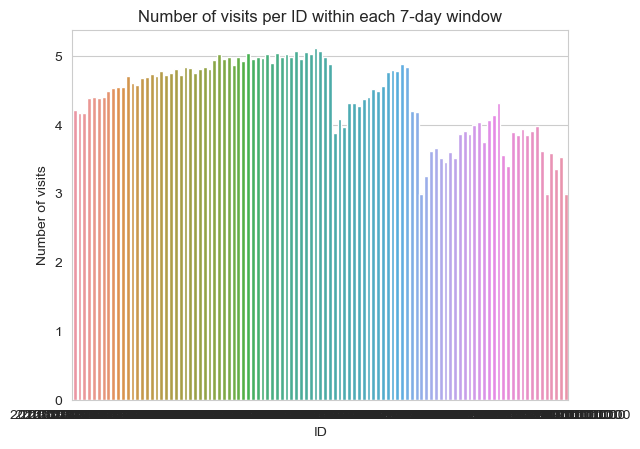

In [57]:
# alternative coding visualization solution
import seaborn as sns
# Load your dataframe
df = pd.read_csv(f2, parse_dates=['time_stamp'],  encoding='latin-1')

# Convert timestamp column to datetime
df['time_stamp'] = pd.to_datetime(df['time_stamp'])

# Group by id and count the number of visits within a 7-day window
counts = df.groupby(['user_id', pd.Grouper(key='time_stamp', freq='7D')])['visited'].count()

# Filter out counts less than 3
counts = counts[counts >= 3]

# Get a list of ids that meet the criteria
ids_with_more_than_3_visits_in_7_days = counts.index.get_level_values(0).unique().tolist()

# Convert the counts dataframe to a wide format
counts = counts.unstack()

# Filter the counts dataframe to only include the ids that meet the criteria
counts = counts.loc[ids_with_more_than_3_visits_in_7_days]

# Plot a bar chart of the number of visits per id within each 7-day window using Seaborn
sns.set_style("whitegrid")
sns.set_palette("bright")
ax = sns.barplot(data=counts, ci=None)
ax.set_xlabel('ID')
ax.set_ylabel('Number of visits')
ax.set_title('Number of visits per ID within each 7-day window')
plt.show()


C:\Users\tonya\AppData\Local\Temp\ipykernel_28464\2203247672.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  counts_id = df3.groupby(['user_id', pd.Grouper(key='time_stamp', freq='7D')])['visited','user_id'].count()


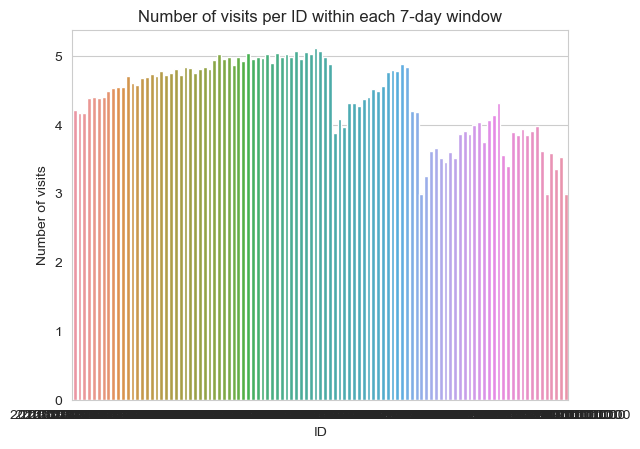

In [76]:
# Load your dataframe
# df3 = pd.read_csv(f2, parse_dates=['time_stamp'],  encoding='latin-1')

# Convert timestamp column to datetime
df3['time_stamp'] = pd.to_datetime(df3['time_stamp'])

# Group by id and count the number of visits within a 7-day window
counts_id = df3.groupby(['user_id', pd.Grouper(key='time_stamp', freq='7D')])['visited','user_id'].count()

# Filter out counts less than 3
counts_id = counts[counts >= 3]

# Get a list of ids that meet the criteria
ids_with_more_than_3_visits_in_7_days2 = counts_id.index.unique().tolist()

# Filter the counts dataframe to only include the ids that meet the criteria
counts_id = counts_id.loc[ids_with_more_than_3_visits_in_7_days2]

# Plot a bar chart of the number of visits per id within each 7-day window using Seaborn
sns.set_style("whitegrid")
sns.set_palette("bright")
ax = sns.barplot(data= counts_id, errorbar= None)
ax.set_xlabel('ID')
ax.set_ylabel('Number of visits')
ax.set_title('Number of visits per ID within each 7-day window')
plt.show()

In [71]:
len(ids_with_more_than_3_visits_in_7_days2)   # 1445
ids_with_more_than_3_visits_in_7_days2[0:10]

[10, 42, 43, 53, 63, 69, 74, 81, 82, 87]

In [84]:
round(1445 / 8823, 3)     # 0.16% are Adopted 

0.164

In [73]:
# Get the total number of ids that meet the criteria of 3 visits min per 7 days
total_ids2 = len(ids_with_more_than_3_visits_in_7_days2)

print("Total number of ids with more than 3 visits per 7-day period:", total_ids2)

Total number of ids with more than 3 visits per 7-day period: 1445


- Out of 8,823 Users (who had logged/visited at least once/7days), we have 68,445 visits happened within a 7 day period and 33,829 visits of 3 or more visits per 7 days. 
- 1445 Users can be considered adopted with more then 3 visits per 7 day period.  
- 16% of all Users are adopted.

What features have those 16% users?

In [88]:
# Print the ids that have more than 3 visits per 7-day period
id_list = []
print("Ids with more than 3 visits per 7-day period:")
for id in ids_with_more_than_3_visits_in_7_days2:
    # print(id)
    id_list.append(id)
    
print("Length of Total number of ids with more than 3 visits per 7-day period:", len(id_list))

Ids with more than 3 visits per 7-day period:
Length of Total number of ids with more than 3 visits per 7-day period: 1445


In [116]:
df_instances.columns # Index(['object_id', 'creation_time', 'name', 'email', 'creation_source', 'last_session_creation_time',
# 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id'],  dtype='object')
df_instances.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [142]:

# Load your dataframe containing the list of ids
df_ids = pd.DataFrame(id_list)
df_ids['id'] = df_ids
# del df_ids[0]
df_ids.head()
# Load your dataframe containing the instances of the ids
df_instances = df2.copy()
df_instances.object_id.nunique()    #  12000

# Extract the list of ids from df_ids
id_list2 = df_ids['id'].tolist()

# Filter the instances dataframe to only show instances where the id is in the id_list
df_filtered = df_instances[df_instances['object_id'].isin(id_list)]

df_filtered_invited_others = df_instances[df_instances['invited_by_user_id'].isin(id_list)]

print(f'{len(df_filtered_invited_others)/ 1200}% of Users have Invited other Users' )       #    996
print(f'{round(len(df_filtered) / 12000, 2)}% (or {len(df_filtered)}) from the 12,000 Users are adopted Users.' )  


0.83% of Users have Invited other Users
0.12% (or 1445) from the 12,000 Users are adopted Users. 


- Let's find their features.


In [146]:
# copy the df with adopted users
adopted = df_filtered.copy()
adopted.head()
# adopted.shape    #(1445, 10)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0
41,42,2012-11-11 19:05:07,Pinto Giovanna,GiovannaCunhaPinto@cuvox.de,SIGNUP,1.401045e+09,1,0,235,NaN
42,43,2012-12-31 07:13:17,Gomes Beatrice,vgqmpljq@yyyxt.com,GUEST_INVITE,1.366010e+09,0,0,63,149.0
52,53,2013-02-09 23:47:15,Ribeiro Camila,CamilaGomesRibeiro@gmail.com,GUEST_INVITE,1.367798e+09,0,0,37,3641.0
62,63,2012-12-20 16:30:52,Martins Leonor,LeonorAraujoMartins@gmail.com,SIGNUP_GOOGLE_AUTH,1.401899e+09,0,0,203,NaN


In [205]:
# all = pd.read_csv('takehome_users.csv',  parse_dates=['creation_time'], encoding='latin')
# all.head()
all.shape      #(12000, 10)

# rename the object_id with user_id
# all = all.rename({'object_id':'user_id'}, axis= 1).set_index('user_id')
all.head()
# all.shape    #(12000, 9)

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
user_id,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [166]:
all.isnull().sum()

creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

In [ ]:
- Convert the object string to dateTime 
- Downsample time_stamp to weekly frequenacy in df.
- set index and group by 'user_id', 'time_stamp'
- sort the index


In [223]:
# df.time_stamp = pd.to_datetime(df['time_stamp'])
df.dtypes              #time_stamp    datetime64[ns]
dfInd = df.set_index(['user_id', 'time_stamp']).sort_index()
dfInd.shape   #(207917, 1)
dfInd.head()

visited
user_id time_stamp                  
1       2014-04-22 03:53:30        1
2       2013-11-15 03:45:04        1
        2013-11-29 03:45:04        1
        2013-12-09 03:45:04        1
        2013-12-25 03:45:04        1

In [224]:

dfInd2 = dfInd.groupby([pd.Grouper(level='user_id'), pd.Grouper(freq= 'W', level= 'time_stamp')]).sum()
dfInd2[dfInd2['visited'] >= 3].head()

visited
user_id time_stamp         
2       2014-02-09        3
10      2013-03-03        3
        2013-04-14        3
        2013-04-28        3
        2013-05-05        4

In [ ]:
- Encode 1 for where visited is engaged, 0 for not engaged (within 7 day period)

In [236]:
adopted = ( (dfInd2['visited'] >= 3).groupby('user_id').sum() >= 1 ).astype('int')

In [257]:
# print(adopted.head())
adopted.shape  # (8823,)
adopted.head()
adopted.describe()


count    8823.000000
mean        0.163776
std         0.370094
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: visited, dtype: float64

In [259]:
adopted_df = pd.DataFrame(adopted).reset_index()
adopted_df.head(3)

,user_id,visited
0,1,0
1,2,1
2,3,0


In [260]:
df2.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


- merge original df with the adopted_df

In [261]:
merged = pd.merge(df2, adopted_df, left_on = "object_id", right_on = "user_id", how = "inner" )
merged.head()
# merged.shape    #(8823, 12)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id,visited
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,3,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,4,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,5,0


In [266]:
# del merged['object_id']
# del merged['email']
merged_red = merged.drop(columns = ['name']).set_index('user_id')
len(merged_red)          #8823

8823

In [268]:
merged_red.nunique()

creation_time                 8821
creation_source                  5
last_session_creation_time    8821
opted_in_to_mailing_list         2
enabled_for_marketing_drip       2
org_id                         417
invited_by_user_id            2229
visited                          2
dtype: int64

- Convert to dummies w one-hot encode, remove 'GUEST_INVITE' the `creation_source`
- `Invited_by_user` is most possibly irrelevant to adoption of Users. We will convert it to Boolean for 1 yes or 0 No. This way we will also automatically avoid the many NaN's in this category, which anyway reduce the significance of this field to Adoption.
- Convert to datetime `creation_time`

In [282]:
len(merged_red['creation_source'].unique()) #  5  this is categorical - convert to dummies w one-hot encode, remove 'GUEST_INVITE'
# merged_red = merged_red.join(pd.get_dummies(merged_red['creation_source'] ))
del merged_red['creation_source']
merged_red.tail()

,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,visited,invited_by_user,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
user_id,,,,,,,,,,,
11996,2013-09-06 06:14:15,1.378448e+09,0,0,89,0,1,1,0,0,0
11997,2013-01-10 18:28:37,1.358275e+09,0,0,200,0,0,0,0,0,1
11998,2014-04-27 12:45:16,1.398603e+09,1,1,83,0,1,0,0,0,0
11999,2012-05-31 11:55:59,1.338638e+09,0,0,6,0,0,0,1,0,0
12000,2014-01-26 08:57:12,1.390727e+09,0,1,0,0,0,0,0,1,0


In [287]:
merged_red['creation_time'] = pd.to_datetime(merged_red['creation_time'])
merged_red['last_session_creation_time'] = pd.to_datetime(merged_red['last_session_creation_time'])

In [275]:
merged_red['invited_by_user']  = merged_red['invited_by_user_id'].notna().astype('int')

In [288]:
# del merged_red['invited_by_user_id']
merged_red.tail()

,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,visited,invited_by_user,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
user_id,,,,,,,,,,,
11996,2013-09-06 06:14:15,1970-01-01 00:00:01.378448055,0,0,89,0,1,1,0,0,0
11997,2013-01-10 18:28:37,1970-01-01 00:00:01.358274517,0,0,200,0,0,0,0,0,1
11998,2014-04-27 12:45:16,1970-01-01 00:00:01.398602716,1,1,83,0,1,0,0,0,0
11999,2012-05-31 11:55:59,1970-01-01 00:00:01.338638159,0,0,6,0,0,0,1,0,0
12000,2014-01-26 08:57:12,1970-01-01 00:00:01.390726632,0,1,0,0,0,0,0,1,0


- Make 2 derivatives on Day and Month from `creation_time`

In [291]:
merged_red['month_created'] = merged_red['creation_time'].dt.month
merged_red['day_created'] = merged_red['creation_time'].dt.day
# del merged_red['creation_time']  # delete 'creation_time'

In [294]:
merged_red.sample(5)

,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,visited,invited_by_user,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,month_created,day_created
user_id,,,,,,,,,,,,
753,1970-01-01 00:00:01.374590832,0,0,47,0,0,0,0,0,1,7,16
60,1970-01-01 00:00:01.400194563,0,0,88,0,1,1,0,0,0,3,21
3915,1970-01-01 00:00:01.400661566,1,1,185,1,1,1,0,0,0,9,12
1533,1970-01-01 00:00:01.387535371,0,0,214,0,1,1,0,0,0,12,18
8025,1970-01-01 00:00:01.401917341,0,0,22,1,0,0,1,0,0,9,11


In [295]:
len(merged_red['org_id'].unique())

417